In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])

In [30]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [31]:
df.dtypes

date        object
Ex_rate    float64
dtype: object

In [32]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


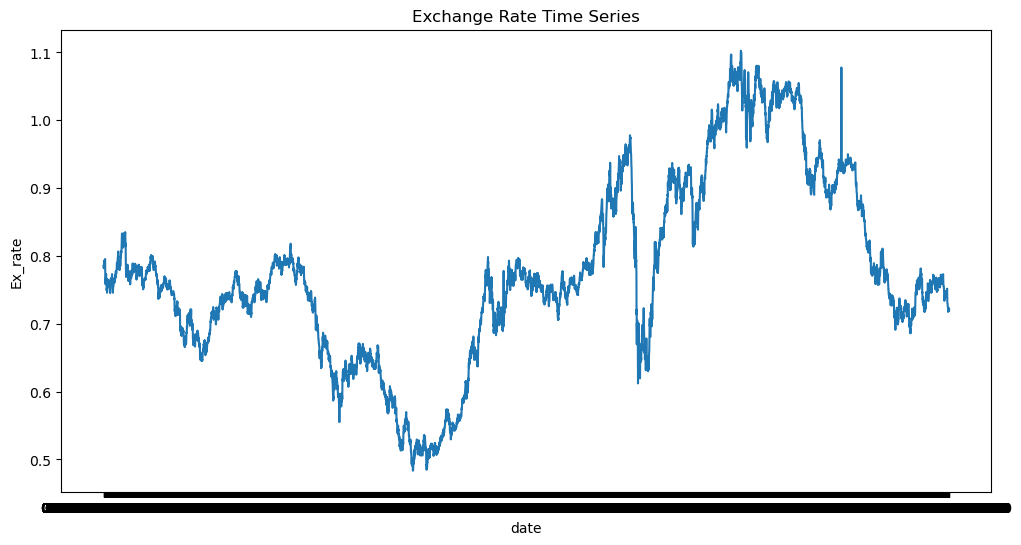

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='Ex_rate', data=df)
plt.title('Exchange Rate Time Series')
plt.xlabel('date')
plt.ylabel('Ex_rate')
plt.show()

In [42]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

# Part 2: Model Building - ARIMA

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA

In [49]:
ts_df= df['Ex_rate']

In [51]:
ts_df_log= np.log(ts_df)

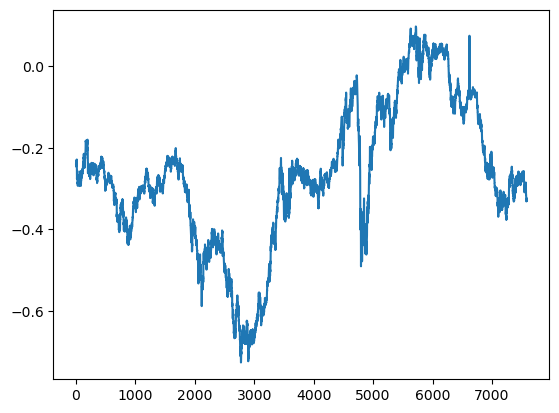

In [53]:
plt.plot(ts_df_log)

In [55]:
def test_stationarity(timeseries):

    #Calculate rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    original = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')

    print('Results of Dickey-Fuller Test :\n')
    df_test = adfuller(timeseries)
    my_output = pd.Series(df_test[0:4], index =['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for i,j in df_test[4].items():
        my_output['Critical Value (%s)'%i] =j
    print(my_output)

Results of Dickey-Fuller Test :

Test Statistic                   -1.664994
p-value                           0.449233
#Lags Used                        1.000000
Number of Observations Used    7586.000000
Critical Value (1%)              -3.431212
Critical Value (5%)              -2.861921
Critical Value (10%)             -2.566973
dtype: float64


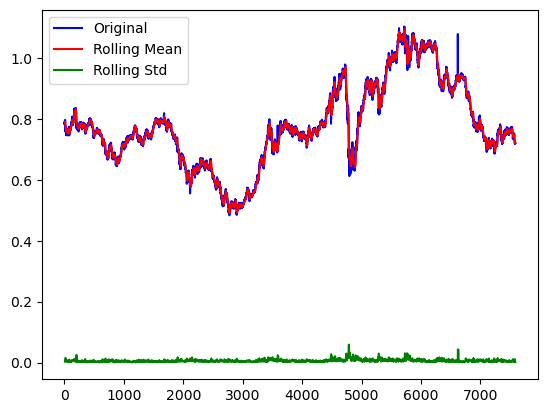

In [57]:
test_stationarity(df['Ex_rate'])

In [59]:
adfuller(df['Ex_rate'])

(-1.6649941807382331,
 0.4492327353597483,
 1,
 7586,
 {'1%': -3.4312123140180137,
  '5%': -2.861921078147796,
  '10%': -2.5669728434336108},
 -55835.06254628545)

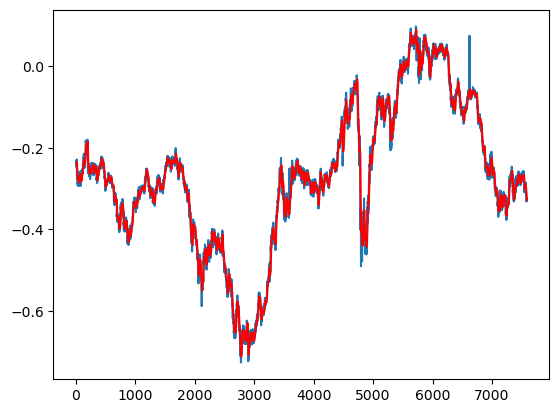

In [61]:
movingAverage = ts_df_log.rolling(window = 12).mean()
plt.plot(ts_df_log)
plt.plot(movingAverage, color='red')

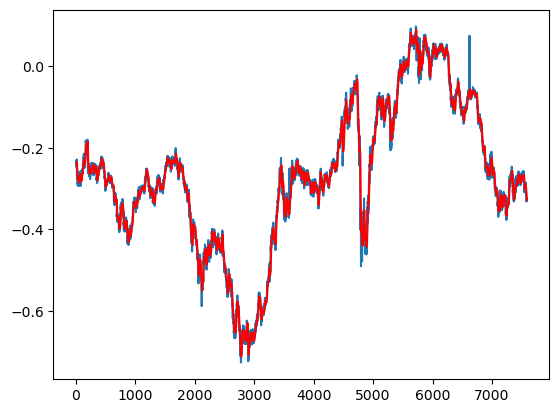

In [63]:
movingAverage = ts_df_log.rolling(window = 12).mean()
movingSTD = ts_df_log.rolling(window = 12).std()
plt.plot(ts_df_log)
plt.plot(movingAverage,color='red')

In [65]:
ts_df_log_diff = ts_df_log - movingAverage
ts_df_log_diff.head(15)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11    0.007278
12    0.005678
13    0.006632
14   -0.017983
Name: Ex_rate, dtype: float64

In [67]:
ts_df_log_diff.dropna(inplace=True)
ts_df_log_diff.shape

(7577,)

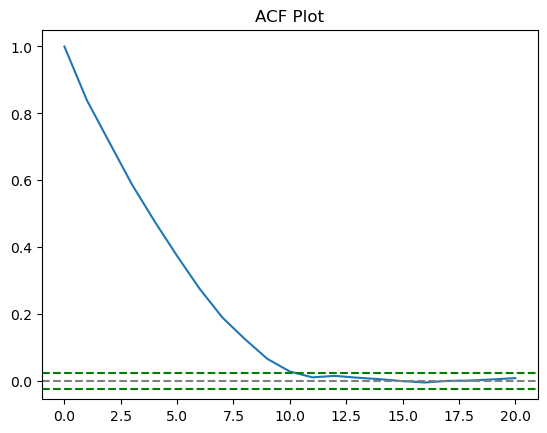

In [69]:
# Plotting the ACF curve

plt.plot(np.arange(0,21), acf(ts_df_log_diff, nlags = 20))
plt.axhline(y=0, linestyle = '--', color = 'gray')
#Confidence intervals
plt.axhline(y=-1.96/np.sqrt(len(ts_df_log_diff)), linestyle = '--', color = 'green')
plt.axhline(y=1.96/np.sqrt(len(ts_df_log_diff)), linestyle = '--', color = 'green')
plt.title('ACF Plot')
plt.show()

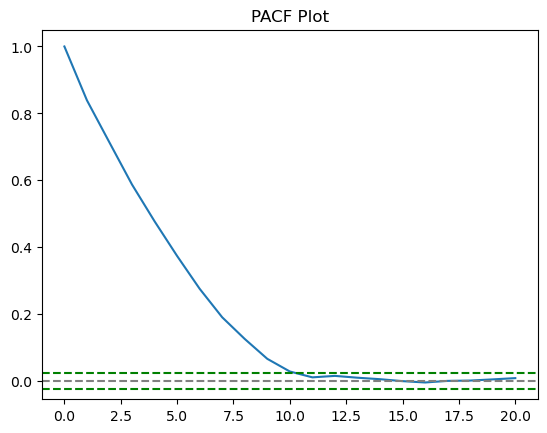

In [71]:
# Plotting the PACF curve

plt.plot(np.arange(0,21), acf(ts_df_log_diff, nlags = 20))
plt.axhline(y=0, linestyle = '--', color = 'gray')
#Confidence intervals
plt.axhline(y=-1.96/np.sqrt(len(ts_df_log_diff)), linestyle = '--', color = 'green')
plt.axhline(y=1.96/np.sqrt(len(ts_df_log_diff)), linestyle = '--', color = 'green')
plt.title('PACF Plot')
plt.show()

# Forecasting

In [74]:
import statsmodels.api as sm

In [76]:
# Parameter selection (assuming p=1, d=1, q=1 based on ACF and PACF plots)
model = sm.tsa.arima.ARIMA(ts_df_log, order=(1, 1, 1))
results = model.fit()

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               26253.679
Date:                Tue, 11 Feb 2025   AIC                         -52501.358
Time:                        03:07:13   BIC                         -52480.555
Sample:                             0   HQIC                        -52494.219
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1083      0.060     -1.813      0.070      -0.225       0.009
ma.L1          0.0074      0.060      0.124      0.901      -0.110       0.125
sigma2       5.78e-05   2.05e-07    281.565      0.0

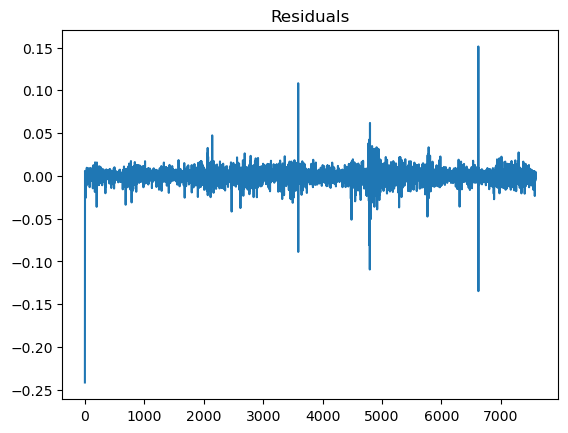

In [78]:
# Diagnostics
print(results.summary())
plt.plot(results.resid)
plt.title('Residuals')
plt.show()

In [82]:
forecast = results.forecast(steps=10)  # Forecast for the next 10 periods
print(forecast)

7588   -0.327361
7589   -0.327361
7590   -0.327361
7591   -0.327361
7592   -0.327361
7593   -0.327361
7594   -0.327361
7595   -0.327361
7596   -0.327361
7597   -0.327361
Name: predicted_mean, dtype: float64


# Model Building

In [85]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [87]:
from statsmodels.tsa.arima.model import ARIMA

In [89]:
model = ARIMA(df['Ex_rate'], order=(1,1,1))

In [91]:
result = model.fit()

In [93]:
result

<Axes: >

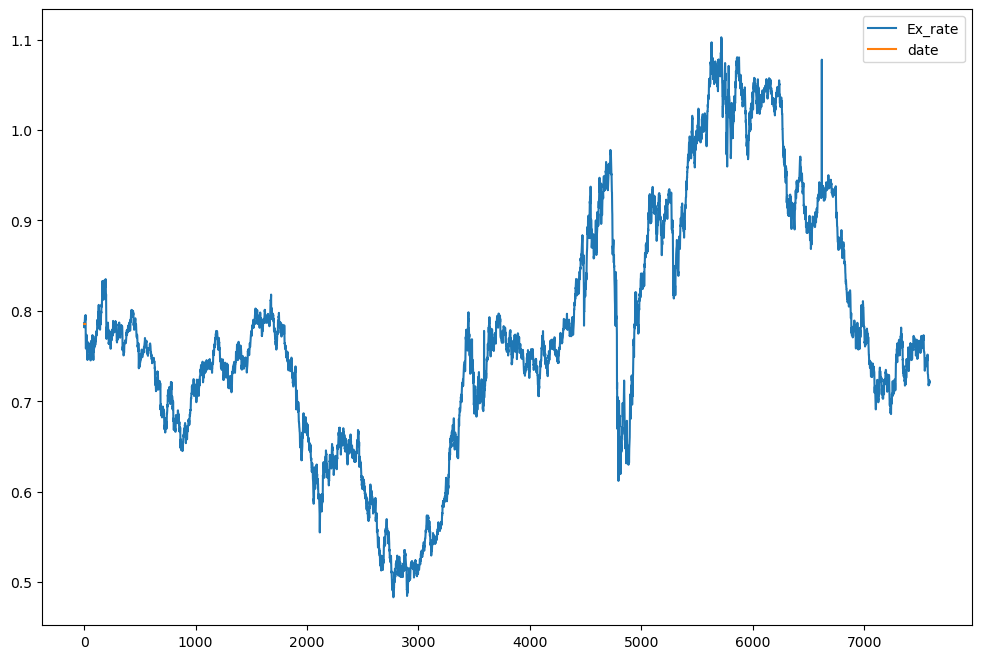

In [95]:
df['date']= result.predict(start=1,end=10,dynamic=True)
df[['Ex_rate','date']].plot(figsize=(12,8))

Results of Dickey-Fuller Test :

Test Statistic                -1.404275e+01
p-value                        3.281274e-26
#Lags Used                     2.900000e+01
Number of Observations Used    7.547000e+03
Critical Value (1%)           -3.431217e+00
Critical Value (5%)           -2.861923e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


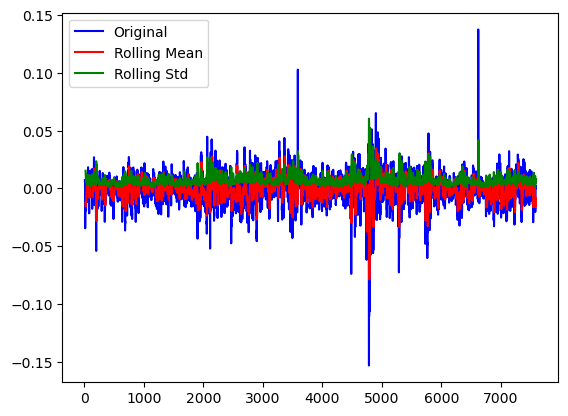

In [97]:
test_stationarity(ts_df_log_diff)

In [99]:
result.predict()

0       0.000000
1       0.785500
2       0.782286
3       0.786058
4       0.786089
          ...   
7583    0.718837
7584    0.718522
7585    0.721400
7586    0.723017
7587    0.721136
Name: predicted_mean, Length: 7588, dtype: float64

In [101]:
result.forecast(steps=20)

7588    0.720826
7589    0.720826
7590    0.720826
7591    0.720826
7592    0.720826
7593    0.720826
7594    0.720826
7595    0.720826
7596    0.720826
7597    0.720826
7598    0.720826
7599    0.720826
7600    0.720826
7601    0.720826
7602    0.720826
7603    0.720826
7604    0.720826
7605    0.720826
7606    0.720826
7607    0.720826
Name: predicted_mean, dtype: float64

In [103]:
result.fittedvalues

0       0.000000
1       0.785500
2       0.782286
3       0.786058
4       0.786089
          ...   
7583    0.718837
7584    0.718522
7585    0.721400
7586    0.723017
7587    0.721136
Length: 7588, dtype: float64

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.55313D+00    |proj g|=  4.87448D+01

At iterate    5    f= -3.61276D+00    |proj g|=  1.11285D-01

At iterate   10    f= -3.61284D+00    |proj g|=  2.64835D+00

At iterate   15    f= -3.62047D+00    |proj g|=  2.01849D+01

At iterate   20    f= -3.62689D+00    |proj g|=  5.94374D-02

At iterate   25    f= -3.62916D+00    |proj g|=  5.97393D+00

At iterate   30    f= -3.66272D+00    |proj g|=  1.62850D+00

At iterate   35    f= -3.66429D+00    |proj g|=  1.28715D-01

At iterate   40    f= -3.68012D+00    |proj g|=  1.38911D+01

At iterate   45    f= -3.68518D+00    |proj g|=  2.77995D+00

At iterate   50    f= -3.68599D+00    |proj g|=  5.71772D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: >

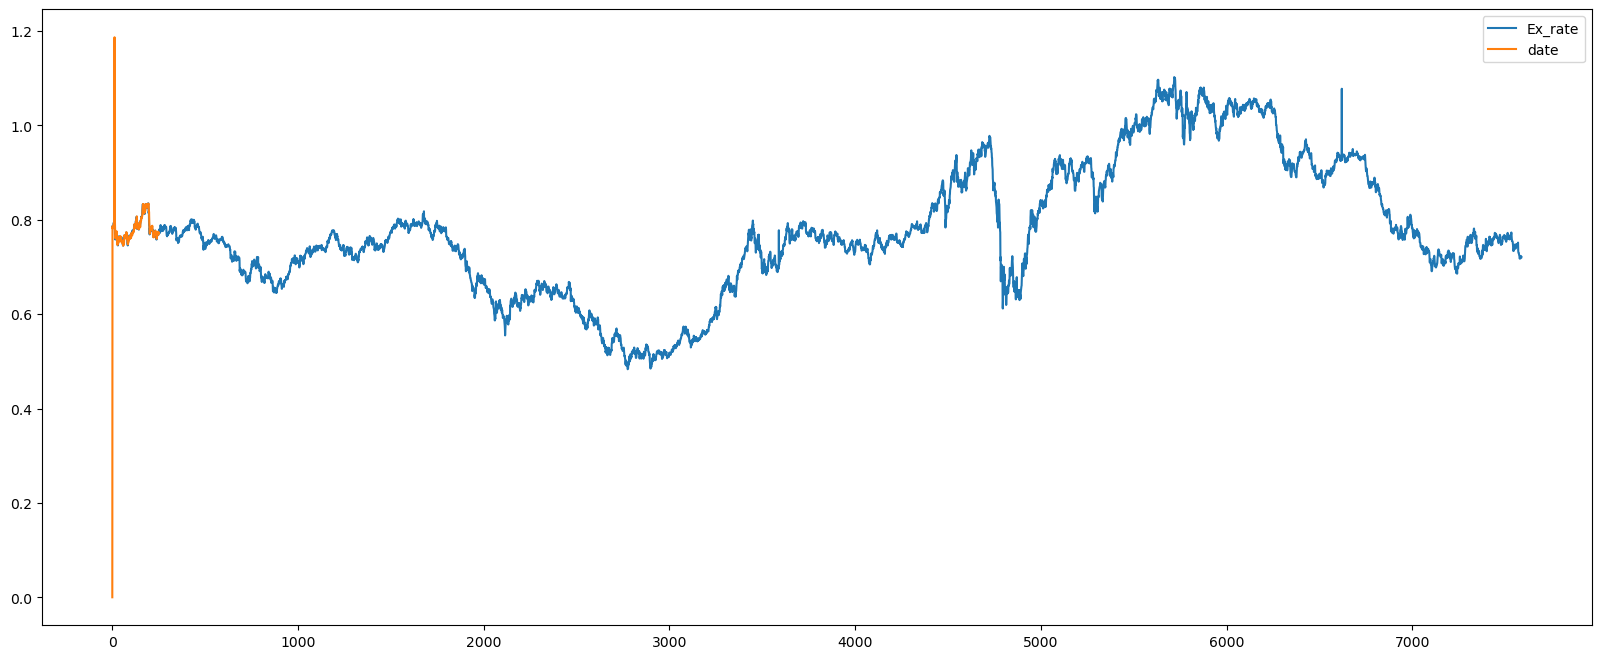

In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
Model= SARIMAX(df['Ex_rate'],order=(1,1,1),seasonal_order=(1,1,1,12))
results1=Model.fit()
df['date']= results1.predict(start=0,end=250)
df[['Ex_rate','date']].plot(figsize=(20,8))

In [107]:
# Fit the Simple Exponential Smoothing model
model = sm.tsa.SimpleExpSmoothing(df['Ex_rate']).fit()

In [109]:
# Forecast future values
forecast = model.forecast(steps=30)

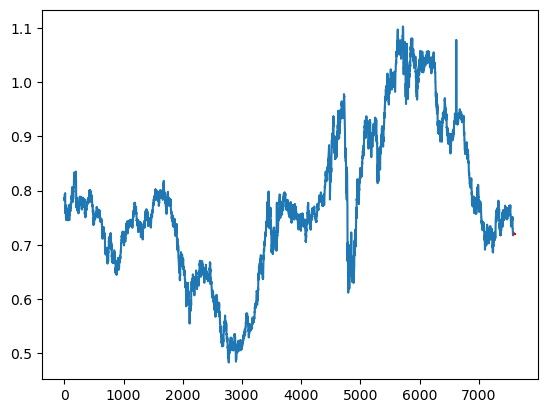

In [111]:
plt.plot(df['Ex_rate'])
plt.plot(forecast, color='red')
plt.show()

In [113]:
model = sm.tsa.Holt(df['Ex_rate']).fit()
# Forecast future values
forecast = model.forecast(steps=30)


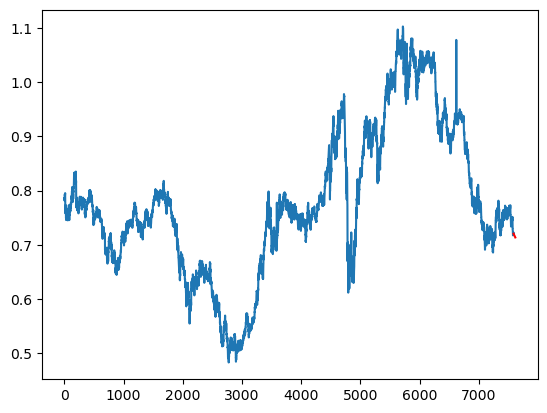

In [115]:
plt.plot(df['Ex_rate'])
plt.plot(forecast, color='red')
plt.show()

In [117]:
# Define the parameter grid
param_grid = {
    'smoothing_level': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'smoothing_trend': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'seasonal_periods': [12, 6, 3, 2],
    'trend': ['additive', 'multiplicative'],
    'damped_trend': [True, False]
}

# Initialize the best model and AIC
best_model = None
best_aic = float('inf')

# Iterate through the parameter grid
for params in param_grid:
    model = sm.tsa.ExponentialSmoothing(df['Ex_rate']).fit()
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic

# Print the best model parameters and AIC
print("Best Model Parameters:")
print(best_model.params)
print("Best AIC:", best_aic)

Best Model Parameters:
{'smoothing_level': 0.8687829828653348, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 0.7851416595387283, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
Best AIC: -77644.98075014984


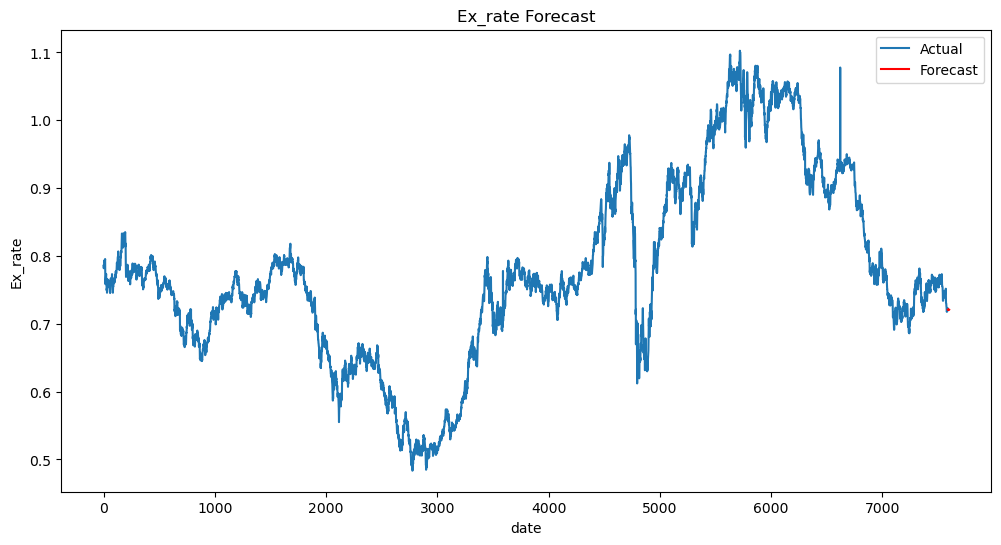

In [119]:
# Fit the Holt-Winters Seasonal model (adjust parameters as needed)
model = sm.tsa.ExponentialSmoothing(df['Ex_rate'], trend='additive', seasonal='additive', seasonal_periods=12).fit()

# Forecast future values (adjust the forecast horizon)
forecast = model.forecast(steps=12)

# Visualize the actual data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Ex_rate Forecast')
plt.xlabel('date')
plt.ylabel('Ex_rate')
plt.legend()
plt.show()

In [121]:
forecast_horizon = 12  # Number of periods to forecast
actual_values = df['Ex_rate'][-forecast_horizon:]  # Select last 'forecast_horizon' values

In [123]:
print("Length of actual_values:", len(actual_values))
print("Length of forecast:", len(forecast))

Length of actual_values: 12
Length of forecast: 12


In [125]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [127]:
# Assuming 'df' contains your exchange rate data
actual_values = df['Ex_rate']

# ... (fit models, generate forecasts) ...

# Check lengths and adjust if necessary
forecast_horizon = len(forecast)
if forecast_horizon < len(actual_values):
    actual_values = actual_values[-forecast_horizon:]  # Slice actual_values

# Calculate error metrics
mae = mean_absolute_error(actual_values, forecast)
rmse = mean_squared_error(actual_values, forecast, squared=False)
mape = mean_absolute_percentage_error(actual_values, forecast)

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 0.0015803678071909244
RMSE: 0.0018638377024949384
MAPE: 0.002192403825839999


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [129]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

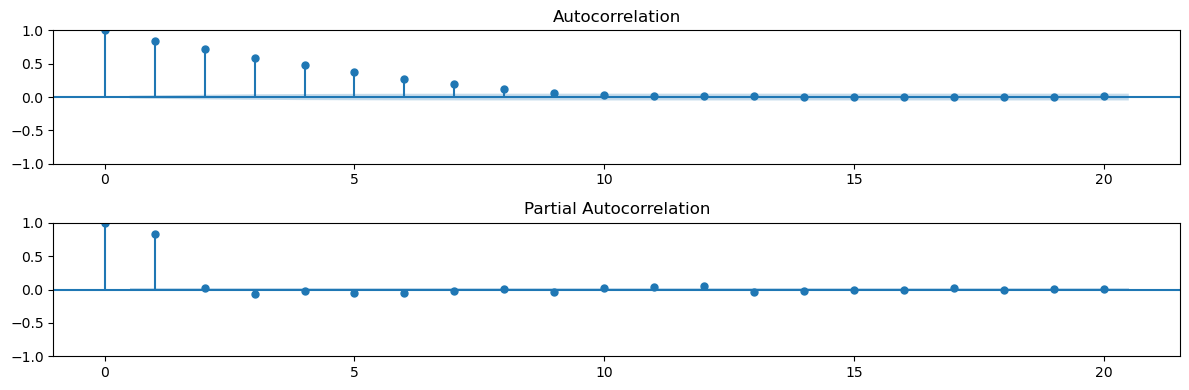

In [131]:
# Assuming you have your time series data in `ts_df_log_diff`
fig, axes = plt.subplots(2, 1, figsize=(12, 4))  # Create a 2x1 subplot

plot_acf(ts_df_log_diff, lags=20, ax=axes[0])

plot_pacf(ts_df_log_diff, lags=20, ax=axes[1])  

plt.tight_layout()
plt.show()

In [139]:
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()
# Forecasting
forecast = model_fit.forecast(steps=10)
# Check stationarity
result = adfuller(df['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    # Differencing if necessary
if result[1] > 0.05:
    df_diff = df.diff().dropna()

ADF Statistic: -1.6649941807382331
p-value: 0.4492327353597483
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
